### Metropolis-adjusted Langevin algorithm (MALA)

$$ Y \sim \mathcal{N}(X_n + h \frac{\nabla\pi(X_n)}{\pi(X_n)}, 2hI) $$

$$ \alpha(X_n, Y) = \frac{\pi(Y)}{\pi(X_n)} \exp \Big\{ \frac{1}{4h}\Big( \big|Y - X_n - h \frac{\nabla\pi(X_n)}{\pi(X_n)}\big|^2 - \big|X_n - Y - h \frac{\nabla\pi(Y)}{\pi(Y)}\big|^2 \Big) \Big\}$$

In [7]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [76]:
def mala(pi, grad_pi, x_0, h, n_of_steps):
    #x = x_0
    x = np.zeros((n_of_steps, x_0.size))
    x[0] = x_0
    #sumx = np.zeros(x_0.shape)
    scale = np.sqrt(2*h)
    for i in range(1, n_of_steps):
        y = np.random.normal(x[i-1]+(h/pi(x[i-1]))*grad_pi(x[i-1]), scale)
        sqsum1 = np.sum((y-x[i-1]-(h/pi(x[i-1]))*grad_pi(x[i-1]))**2)
        sqsum2 = np.sum((x[i-1]-y-(h/pi(y))*grad_pi(y))**2)
        alpha_cand = (pi(y)/pi(x[i-1])) * np.exp( (sqsum1 - sqsum2) / (4*h) )
        alpha = min(alpha_cand, 1)
        if np.random.rand() < alpha:
            x[i] = y
        else:
            x[i] = x[i-1]
    return x

In [77]:
def norm(x):
    return (1/np.sqrt(2*np.pi))*np.exp(-x**2/2)

def grad_norm(x):
    return -(x/np.sqrt(2*np.pi))*np.exp(-x**2/2)

In [78]:
mala_samples = mala(norm, grad_norm, np.array([0]), 0.01, 10**5)

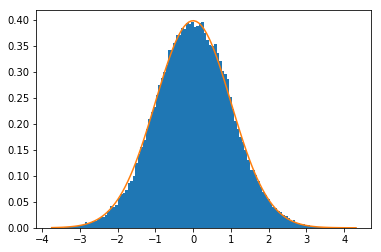

In [80]:
mala_dens, bins, _ = plt.hist(mala_samples, bins=120, density=True)
dens = np.zeros((bins.size, 1))
for i in range(dens.size):
    dens[i] = norm(bins[i])
plt.plot(bins, dens)

### Hamiltonian Monte Carlo (HMC)

Startujemy z rozkładu $$ \pi(q) = e^{-V(q)}. $$
Dodajemy sztuczną zmienną (pęd) $p$:
$$ \pi(q,p) = \pi(q)\pi(p|q) = e^{-V(q)-K(p,q)}.$$
Zazwyczaj $K(p,q) = \frac{p^Tp}{2}.$

$$ H(q,p) = V(q) + K(p,q) $$
Chcemy
$$ \frac{\partial}{\partial t} H = 0 $$
czyli
$$ \frac{\partial q}{\partial t} = \frac{\partial H}{\partial p} $$
$$ \frac{\partial p}{\partial t} = - \frac{\partial H}{\partial q} $$


bo wtedy zachowamy łączny rozkład, więc w szczególności zachowamy brzegowy.

##### LFI:

$p^0, q^0 \rightarrow p^1, q^1$

$\varepsilon$ - krok dyskretyzacji

$$p^{\frac 1 2} = p^0 - \frac \varepsilon 2 \frac{\partial V}{\partial q}(q^0)$$
$$ q^1 = q^0 + \varepsilon p^{\frac 1 2}$$
$$ p^1 = p^{\frac 1 2} - \frac \varepsilon 2 \frac{\partial V}{\partial q}(q^1)$$

In [49]:
def hamiltonian_lfi(p0, q0, grad_v, epsilon, l):
    p = p0
    q = q0
    for i in range(l):
        p_half = p - (epsilon/2)*grad_v(q)
        q += epsilon * p_half
        p = p_half - (epsilon/2) * grad_v(q)
    return np.stack((q,p))

##### Algorytm:

$ q_n \rightarrow q_{n+1} $

1. $q^0 = q_n, p_0 \sim \mathcal{N}(0, \text{Id})$
2. $q^0, p^0 \rightarrow q^l, p^l$ - Leap Frog Integrator
3. $\alpha = \exp\{-V(q^l) - K(-p^l) + V(q^0) + K(p^0)\} \wedge 1$ (dajemy $-p^l$, ale to jest symetryczne)
4. $q_{n+1} = q^l$ z prawdopodobieństwem $\alpha$

In [50]:
def hmc(q_0, epsilon, l, v, grad_v, n, k=lambda p: np.sum(p**2)):
    q_vec = np.zeros((n,q_0.size))
    q_vec[0] = q_0
    for i in range(1, n):
        q = q_vec[i-1]
        p = np.random.randn(q.size)
        alpha_2nd = v(q) + k(p)
        q, p = hamiltonian_lfi(p, q, grad_v, epsilon, l)
        alpha_1st = -v(q) - k(-p)
        alpha_cand = np.exp(alpha_1st + alpha_2nd)
        alpha = min(1, alpha_cand)
        if np.random.rand() < alpha:
            q_vec[i] = q
        else:
            q_vec[i] = q_vec[i-1]
    return q_vec

In [51]:
def v_for_normal(q):
    n = q.size
    return np.sum(q**2)/2 + (n/2)*np.log(2*np.pi)

def grad_v(q):
    return q

In [59]:
qs = hmc(np.zeros((1,1)), 0.001, 100, v_for_normal, grad_v, 10**5)

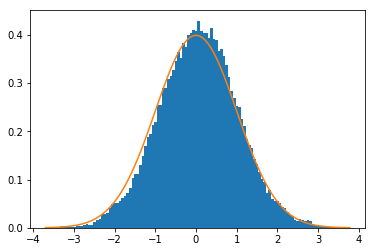

In [60]:
n, bins, _ = plt.hist(qs[:,0], bins=120, density=True)
dens = np.zeros((bins.size, 1))
for i in range(dens.size):
    dens[i] = np.exp(-v_for_normal(bins[i]))
plt.plot(bins, dens)